# YOLO v7 Data Visualizer
This is a simple visualizer for YOLO v7 datasets

In [1]:
%matplotlib widget
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


def get_name(file):
    return os.path.splitext(os.path.basename(file))[0]

In [2]:
images_path = "D:\\data\\COCO\\coco\\images\\"
annotations_path = "D:\\data\\COCO\\coco\\labels\\"

image_files = dict()
label_files = dict()

for root, subdirs, files in os.walk(images_path):
    if not files or 'test2017' in root:
        continue

    print(f'Found {len(files)} files in {root}, adding')
    image_files.update([[get_name(f), os.path.join(root, f)] for f in files])

for root, subdirs, files in os.walk(annotations_path):
    if not files:
        continue

    print(f'Found {len(files)} files in {root}, adding')
    label_files.update([[get_name(f), os.path.join(root, f)] for f in files])


print(f'Loaded {len(image_files)} images, {len(label_files)} labels')

coco_classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

Found 118287 files in D:\data\COCO\coco\images\train2017, adding
Found 5000 files in D:\data\COCO\coco\images\val2017, adding
Found 117266 files in D:\data\COCO\coco\labels\train2017, adding
Found 4952 files in D:\data\COCO\coco\labels\val2017, adding
Loaded 123287 images, 122218 labels


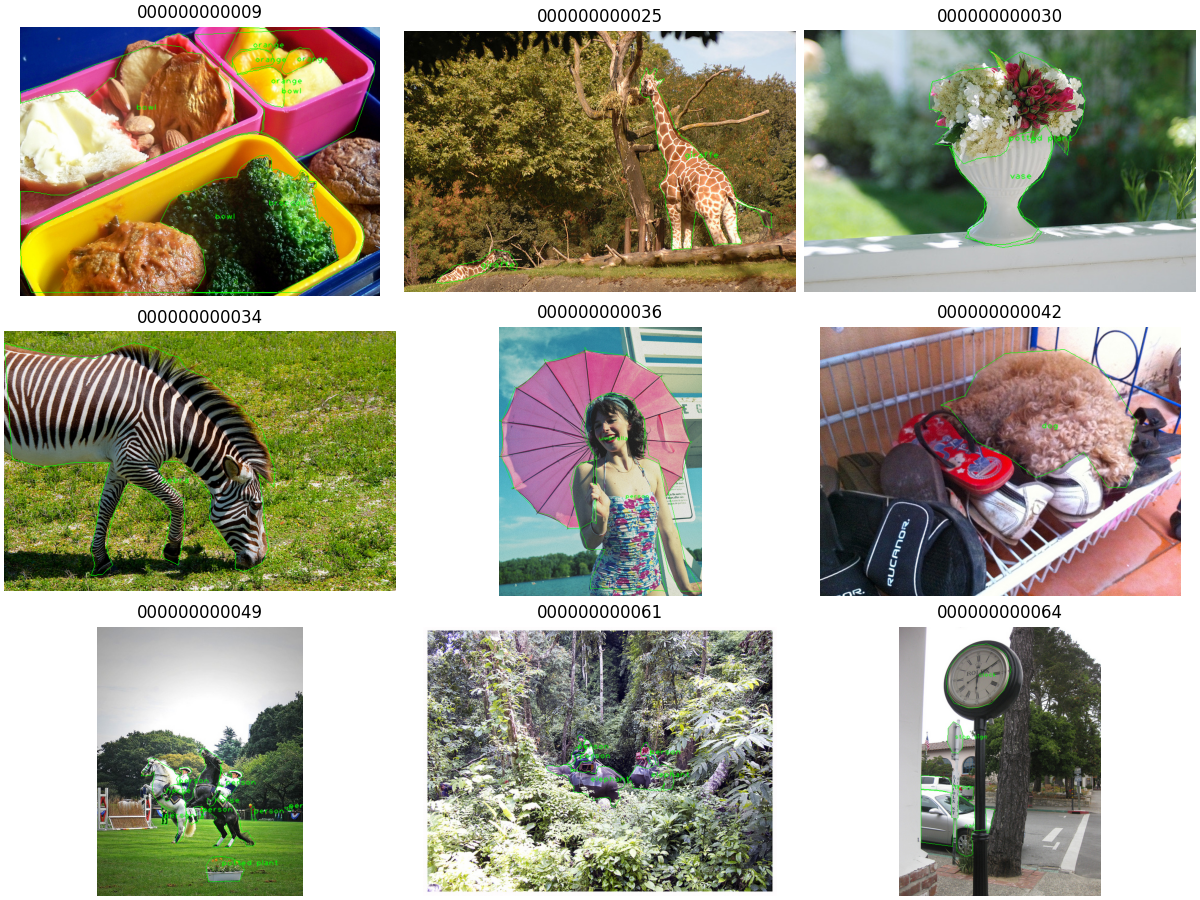

In [3]:
samples = 9
plt.close()
fig, ax = plt.subplots(3, 3, figsize=(12, 9), num='Samples', layout='constrained')
ax = ax.flatten()
idx = 0

for k, v in image_files.items():
    if k not in label_files:
        continue

    if idx >= samples:
        break

    label_file = label_files[k]
    with open(label_file) as f:
        anns = f.readlines()

    img = cv.imread(v)

    mult = np.array(img.shape[:-1][::-1])

    for a in anns:
        a = a.split()
        cls = int(a[0])
        poly = np.array([float(n) for n in a[1:]]).reshape(-1, 2)
        poly *= mult
        centroid = np.mean(poly, axis=0).astype(np.int32)
        poly = poly.reshape(-1, 1, 2).astype(np.int32)
        cv.polylines(img, [poly], True, (0, 255, 0))
        cv.putText(img, coco_classes[cls], centroid, cv.FONT_HERSHEY_PLAIN, 1., (0, 255, 0), 1, cv.LINE_AA)

    ax[idx].imshow(img[:,:,::-1])
    ax[idx].axis(False)
    ax[idx].title.set_text(k)
    idx += 1

plt.show()

In [4]:
filter_cats = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter']

to_keep = []

In [5]:
for k in tqdm(image_files.keys(), desc='Processing'):
    if k not in label_files:
        continue

    label_file = label_files[k]
    with open(label_file) as f:
        anns = f.readlines()

    for a in anns:
        a = a.split()
        if coco_classes[int(a[0])] in filter_cats:
            to_keep.append(k)
            break

print(f'Keeping {len(to_keep)} images.')

Processing:   0%|          | 0/123287 [00:00<?, ?it/s]

Keeping 76819 images.


In [6]:
from sklearn.model_selection import train_test_split

train_keys, val_keys = train_test_split(to_keep, test_size=0.20, random_state=42)

print(f'Train: {len(train_keys)}, test: {len(val_keys)}')

Train: 61455, test: 15364


In [4]:
out_dir = "D:\\data\\COCO\\coco_VRU_subset\\"
out_images_train = os.path.join(out_dir, 'images', 'train')
out_images_val = os.path.join(out_dir, 'images', 'val')
out_labels_train = os.path.join(out_dir, 'labels', 'train')
out_labels_val = os.path.join(out_dir, 'labels', 'val')

if not os.path.exists(out_images_train):
    os.makedirs(out_images_train)

if not os.path.exists(out_images_val):
    os.makedirs(out_images_val)

if not os.path.exists(out_labels_train):
    os.makedirs(out_labels_train)

if not os.path.exists(out_labels_val):
    os.makedirs(out_labels_val)

In [139]:
import shutil


def process_dataset(keys, images, labels, filters, out_image_dir, out_label_dir):
    filter_map = dict([[k, i] for i, k in enumerate(filters)])

    for k in tqdm(keys, desc=f'Processing {get_name(out_image_dir)}'):
        img_file = images[k]
        label_file = labels[k]

        out_label_file = os.path.join(out_label_dir, f'{get_name(label_file)}.txt')
        if os.path.exists(out_label_file):
            continue
        
        shutil.copy(img_file, out_image_dir)
        with open(label_file) as f:
            anns = f.readlines()

        with open(out_label_file, 'w') as f:
            for a in anns:
                linedata = a.split()
                coco_label = int(linedata[0])
                if coco_label in filters:
                    linedata[0] = filter_map[coco_label]
                    f.write(a)

In [5]:
with open(os.path.join(out_dir, 'classes.csv'), 'w') as f:
    f.write(','.join(filter_cats))

process_dataset(val_keys, image_files, label_files, filter_cats, out_images_val, out_labels_val)
process_dataset(train_keys, image_files, label_files, filter_cats, out_images_train, out_labels_train)